---
---
# **Clickbait Content Spoiling**

---
---
## Abstract

This project undertakes the task of fine-tuning a RoBERTa transformer for a specific classification objective. Leveraging the contextual embeddings acquired through pre-training, the RoBERTa model is adapted for the classification of the type of spoiler that clickbait content warrents (either `phrase`, `passage`, `multi`).

---
---
## Table of Contents

>[Clickbait Content Spoiling](#scrollTo=jS4TDEkfQGdS)

>>[Abstract](#scrollTo=eqHZXclYQGbB)

>>[Table of Contents](#scrollTo=UEplxkDaQGY9)

>>[Background](#scrollTo=E-IEK_4mQgrt)

>>>[Clickbait Type Classification](#scrollTo=KfxZJdDt999x)

>>>[Dataset](#scrollTo=9x-xmtWt-rhk)

>>[Implementation](#scrollTo=pPoaLvhZQnLa)

>>>[Setup](#scrollTo=DvYUOv8RRCcx)

>>>[Imports](#scrollTo=RROIj03oRCQP)

>>>[Dataset: Preparation](#scrollTo=wPzIozEgRCGx)

>>>[Dataset: Exploration](#scrollTo=yYxSrwnuWOv6)

>>>[Dataset: Tokenization](#scrollTo=hfX7y0ylUO11)

>>>[Evaluation Metric](#scrollTo=Lx89A5jLFx-q)

>>>[Fine-Tuning](#scrollTo=c0vCqQ38dheG)

>>>[Inference](#scrollTo=X509pE-iOYbq)



---
---
## Background

### Clickbait Type Classification

Clickbait posts link to web pages and advertise their content by arousing curiosity instead of providing informative summaries. This task aims at labelling clickbait posts with the type of spoiler they warrent. Shown below are the three different types:

- `phrase`: where the spoiler is a single sentence.
- `passage`: where the spoiler is a single paragraph.
- `multi`: where there are multiple required spoilers.

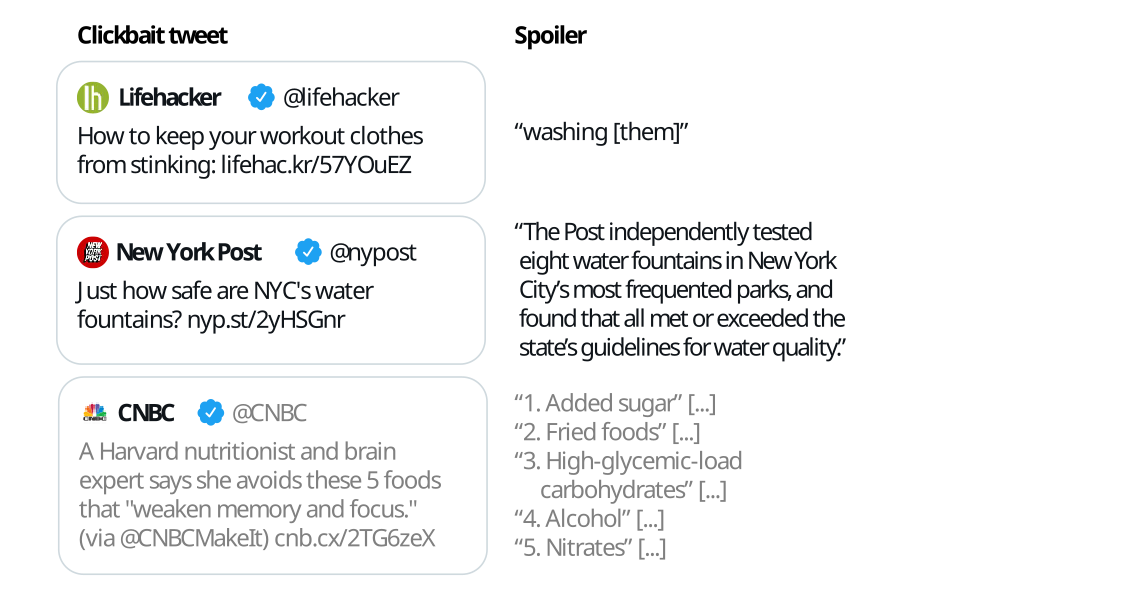

### Dataset

The Webis Clickbait Spoiling Corpus contains
5,000 spoiled clickbait posts crawled from Facebook, Reddit, and Twitter. This dataset contains the clickbait posts and manually cleaned versions
of the linked documents, and extracted spoilers
for each clickbait post. Additionally, the spoilers are categorized into three types: short phrase
spoilers, longer passage spoilers, and multiple non-
consecutive pieces of text.

The dataset comes with predefined train/validation/test splits:


*   3,200 posts for training
*   800 posts for validation
*   1,000 posts for testing (omitted from the dataset)

Thus, for development, the training samples are
split into 3,000 for training and 200 for validation.
The 800 validation samples are used as a test set.

---
---
## Implementation

### Setup

This section installs the most recent versions of:

- 🤗Transformers
- 🤗Datasets
- 🤗Evaluate

In [1]:
!pip install -q transformers accelerate datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00


### Imports

In [2]:
# Dataset Preparation
import json
import numpy as np

import itertools
from collections import Counter
from sklearn.metrics import confusion_matrix

In [3]:
# Hugging Face
import torch
import evaluate
from datasets import Dataset, DatasetDict, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    pipeline
)

In [4]:
# Matplotlib
import matplotlib.pyplot as plt

# plt.rcdefaults()
plt.rcParams["figure.facecolor"] = "#383838"
plt.rcParams["axes.facecolor"] = "#383838"

FONT_COLOUR = "white"
plt.rcParams["text.color"] = FONT_COLOUR
plt.rcParams["xtick.color"] = FONT_COLOUR
plt.rcParams["ytick.color"] = FONT_COLOUR
plt.rcParams["axes.edgecolor"] = FONT_COLOUR
plt.rcParams["axes.labelcolor"] = FONT_COLOUR

In [5]:
# Mount Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### Dataset: Preparation

In [8]:
import json
from datasets import Dataset, DatasetDict

def read_jsonl_file(file_path):
    """
    Reads a JSONL file containing example data and converts it into a list of dictionaries.

    Args:
        file_path (str): The path to the JSONL file.

    Returns:
        list: A list of dictionaries, each containing 'text' and 'label' keys.
    """
    list_of_example_dicts = []

    with open(file_path, "r") as f:
        for line in f:
            data = json.loads(line)

            # Extracting content, query, and spoiler information from JSON data
            content_list = data.get("targetParagraphs", [])

            # Joining content lists into a single string
            content = " ".join(content_list)

            # Extract the title and tag
            title = data["targetTitle"]
            tag = data["tags"][0]

            # Creating combined text dictionary
            combined_text = {
                "text": title,
                "label": tag
            }
            list_of_example_dicts.append(combined_text)
    return list_of_example_dicts

def create_dataset(train_file_path, test_file_path, val_percentage, seed):
    """
    Creates a dataset from JSONL files for training, testing, and validation.

    Args:
        train_file_path (str): The path to the training JSONL file.
        test_file_path (str): The path to the testing JSONL file.
        val_percentage (float): The percentage of data to be used for validation.
        seed (int): The random seed for data splitting.

    Returns:
        datasets.DatasetDict: A dictionary containing 'train', 'val', and 'test' datasets.
    """
    # Read data from JSONL files
    train_data = read_jsonl_file(train_file_path)
    test_data = read_jsonl_file(test_file_path)

    # Create datasets from dictionaries
    ds_train = Dataset.from_dict({"text": [item["text"] for item in train_data], "label": [item["label"] for item in train_data]})
    ds_test = Dataset.from_dict({"text": [item["text"] for item in test_data], "label": [item["label"] for item in test_data]})

    # Splitting train dataset into train and validation
    ds_train_val = ds_train.train_test_split(test_size=val_percentage, seed=seed)

    # Creating DatasetDict containing train, validation, and test datasets
    ds = DatasetDict({
        "train": ds_train_val["train"],
        "val": ds_train_val["test"],
        "test": ds_test
    })

    return ds

In [9]:
# Specify the dataset directories
dataset_directory_path = "/content/drive/MyDrive/Clickbait Spoiling/data/webis-clickbait"
train_jsonl_path = f"{dataset_directory_path}/train.jsonl"
test_jsonl_path = f"{dataset_directory_path}/validation.jsonl"

# Number of examples for validation subset
val_percentage = 0.0625

# Seed for reproducibility
seed = 42

# Create a Hugging Face Dataset from the dictionary of lists
dataset = create_dataset(
    train_jsonl_path,
    test_jsonl_path,
    val_percentage,
    seed
)

# Print the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 800
    })
})


In [10]:
# Mapping of label strings to integers
label2id = {
    "phrase": 0,
    "passage": 1,
    "multi": 2
}

id2label = {
    0: "phrase",
    1: "passage",
    2: "multi"
}

# Replace labels with integers
def map_labels_to_int(example):
    example["label"] = label2id[example["label"]]
    return example

dataset = dataset.map(map_labels_to_int)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

### Dataset: Exploration

The following section shows an example clickbait content and its spoiler.

In [11]:
# Show an example
n = 0

print(dataset["train"][n]["text"])
print()
print("Spoiler:", dataset["train"][n]["label"])

Why you shouldn't lecture your children about healthy eating

Spoiler: 1


#### Labels Distribution

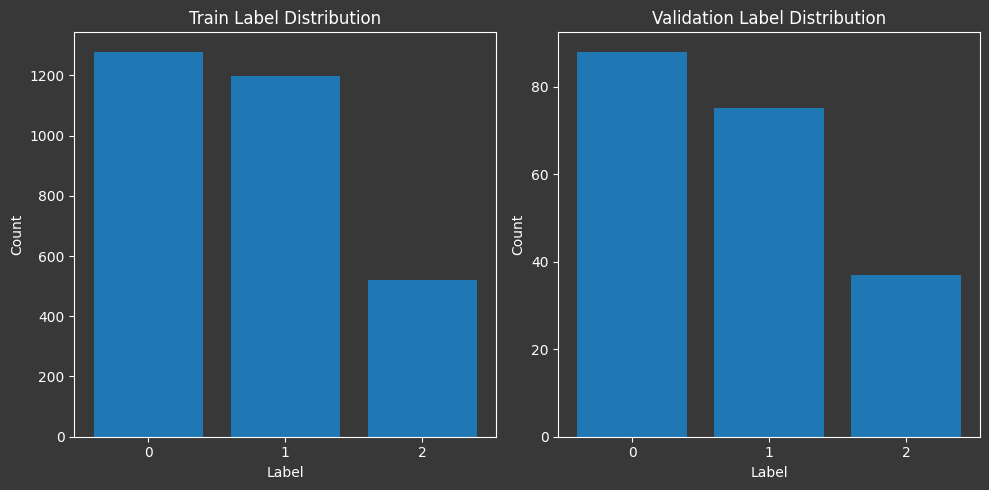

In [12]:
# Count label occurrences using Counter
train_label_counts = Counter(dataset["train"]["label"])
val_label_counts = Counter(dataset["val"]["label"])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot label distribution for train subset
axes[0].bar(train_label_counts.keys(), train_label_counts.values())
axes[0].set_title("Train Label Distribution")

# Plot label distribution for validation subset
axes[1].bar(val_label_counts.keys(), val_label_counts.values())
axes[1].set_title("Validation Label Distribution")

# Add labels and display the plots
for ax in axes:
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    ax.set_xticks(range(3))

plt.tight_layout()
plt.show()

#### Input Lengths

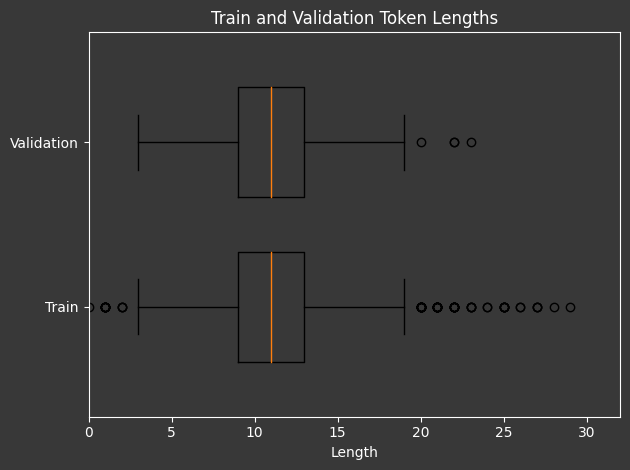

In [15]:
# Extract input text lengths for train and val subsets
train_text_lengths = [len(text.split()) for text in dataset["train"]["text"]]
val_text_lengths = [len(text.split()) for text in dataset["val"]["text"]]

# Create a figure and axis
fig, ax = plt.subplots()

# Create horizontal boxplots for both datasets
boxplot1 = ax.boxplot(train_text_lengths, vert=False, positions=[0.75], widths=0.5)
boxplot2 = ax.boxplot(val_text_lengths, vert=False, positions=[1.5], widths=0.5)

# Add labels and title
ax.set_yticklabels(["Train", "Validation"])
ax.set_xlabel("Length")
ax.set_title("Train and Validation Token Lengths")
ax.set_xlim(0, 32)

# Show the plot
plt.tight_layout()
plt.show()

### Dataset: Tokenization

In [16]:
# Specify the Seq2Seq Transformer Model
base_model_name_hf = "distilroberta-base"

# Load tokenizer of the model
tokenizer = AutoTokenizer.from_pretrained(base_model_name_hf)

In [17]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [18]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 800
    })
})

### Evaluation Metric


In [19]:
# Use accuracy as the evaluation metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### Fine-Tuning

In [72]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name_hf,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
    )

# Specify the training arguments
training_args = TrainingArguments(
    output_dir="BERT_ClickbaitTypeClassifier",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    # weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)


# Fine-tuning
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=concatenate_datasets([tokenized_dataset["train"], tokenized_dataset["val"]]),
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.997629,0.471250
2,No log,0.885427,0.592500
3,No log,0.852995,0.606250
4,0.884100,0.855929,0.616250
5,0.884100,0.860889,0.613750


TrainOutput(global_step=625, training_loss=0.8510755249023437, metrics={'train_runtime': 83.7402, 'train_samples_per_second': 119.417, 'train_steps_per_second': 7.464, 'total_flos': 72961860564000.0, 'train_loss': 0.8510755249023437, 'epoch': 5.0})

### Inference

In [73]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, truncation=True, device=0)

y_pred = classifier(dataset["test"]["text"])
y_pred = [x["label"] for x in y_pred]

y_true = [id2label[id] for id in dataset["test"]["label"]]

Normalized confusion matrix


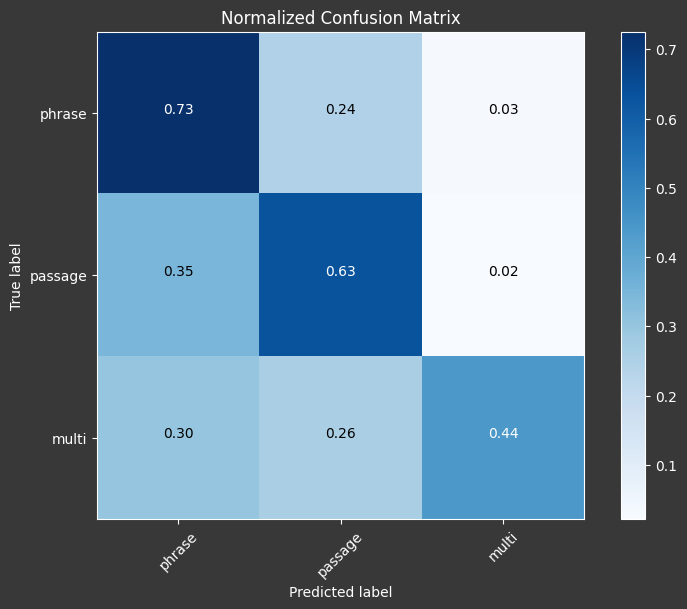

In [59]:
# Get unique class labels
classes = ["phrase", "passage", "multi"]

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=classes)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes, title="Normalized Confusion Matrix", normalize=True)
plt.show()